In [1]:
#week5.1

In [2]:
#import necessary libraries
#pandas for dataset management
import pandas as pd
#matplotlib and seaborn for plots
import seaborn as sns
import matplotlib.pyplot as plt
#import tensorflow for neural network training
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#Sklearn for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
#numpy
import numpy as np

In [3]:
#importing the dataset, cifar10
from tensorflow.keras.datasets import cifar10
#consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class.

In [4]:
#load the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [5]:
#dataset inspection and preprocessing

In [6]:
# Check the range of values
print(f"Train images range: {train_images.min()} to {train_images.max()}")
print(f"Test images range: {test_images.min()} to {test_images.max()}")

Train images range: 0 to 255
Test images range: 0 to 255


In [7]:
#normalize the dataset to the range [0,1] to ensure efficient model training
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [8]:
# Check the range of values again
print(f"Train images range: {train_images.min()} to {train_images.max()}")
print(f"Test images range: {test_images.min()} to {test_images.max()}")

Train images range: 0.0 to 1.0
Test images range: 0.0 to 1.0


In [9]:
#viewing dataset shapes
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing images shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


In [10]:
#looking at the first 5 labels sample
print(f"Train labels sample: {train_labels[:5]}")

Train labels sample: [[6]
 [9]
 [9]
 [4]
 [1]]


In [11]:
#the labels are not binary, using 1 hot encoding

In [12]:
# Define number of classes to encode
num_classes = 10
# One-hot encode the labels
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [13]:
#looking at the first 5 labels sample again
print(f"Train labels sample: {train_labels[:5]}")

Train labels sample: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [14]:
#the labels are now binary

In [15]:
# Create an instance of ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
#produce rotation, width, height and orientation shifts in the images to increase diversity and improve model performance

In [16]:
# Fit the ImageDataGenerator to the training data
datagen.fit(train_images)

In [17]:
#model creation

In [18]:
#3 convolutional and pooling layers with batch normalization and dropout
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Second convolutional layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Third convolutional layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Flattening the output
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [19]:
#Dropout helps reduce overfitting
#Batch Normalization helps stabilize and accelerate training
#both of them improve model performance

In [20]:
#input shape for CIFAR-10
input_shape = (32, 32, 3)

In [62]:
#create the model
model = create_cnn_model(input_shape, num_classes)

D:\Apps\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
#compile the model, using the adam optimizer and the CategoricalCrossentropy loss function
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
#model training

In [24]:
# Define the callbacks
#Model Checkpoint, saves the best model at intervals during training to save model progress/backups in case of training failure
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',  # Filepath to save the model
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,       # Only save the model if `val_accuracy` improves
    mode='max',                # We want to maximize `val_accuracy`
    verbose=1
)

#Early Stopping, saves time and resource by halting the training process when the model has stopped improving
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    mode='min',          # We want to minimize `val_loss`
    restore_best_weights=True,  # Restores model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

In [25]:
# Train the model using the augmented data
model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=50,
    validation_data=(test_images, test_labels),
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/50
  5/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.1455 - loss: 3.2806

D:\Apps\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2570 - loss: 2.3172
Epoch 1: val_accuracy improved from -inf to 0.45760, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.2571 - loss: 2.3167 - val_accuracy: 0.4576 - val_loss: 1.4735
Epoch 2/50
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4149 - loss: 1.5988
Epoch 2: val_accuracy improved from 0.45760 to 0.47210, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.4149 - loss: 1.5987 - val_accuracy: 0.4721 - val_loss: 1.4416
Epoch 3/50
778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4731 - loss: 1.4564
Epoch 3: val_accuracy improved from 0.47210 to 0.51270, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.4731 - loss: 1.4562 - val_accuracy: 0.5127 - val_loss: 1.3788
Epoch 4/50
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5085 - loss: 1.3705
Epoch 4: val_accuracy did not improve from

In [26]:
#the model has been trained, it stopped early at epoch 41/50

In [27]:
#model evaluation

In [28]:
#since we used ModelCheckpoint, it saved the best model
#loading in that best saved model
model = load_model('best_model.keras')

In [29]:
#model evaluation

In [30]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 - 1s - 2ms/step - accuracy: 0.6951 - loss: 0.8705
Test Loss: 0.8704633712768555
Test Accuracy: 0.6951000094413757


In [31]:
#the model accuracy seems good

In [32]:
# Generate predictions for the test dataset
predictions = model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [33]:
# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)
# Define CIFAR-10 class names
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

In [34]:
# Print classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    Airplane       0.67      0.79      0.73      1000
  Automobile       0.87      0.82      0.85      1000
        Bird       0.62      0.52      0.57      1000
         Cat       0.56      0.41      0.47      1000
        Deer       0.69      0.57      0.62      1000
         Dog       0.59      0.62      0.61      1000
        Frog       0.70      0.81      0.75      1000
       Horse       0.64      0.81      0.71      1000
        Ship       0.82      0.76      0.79      1000
       Truck       0.77      0.83      0.80      1000

    accuracy                           0.70     10000
   macro avg       0.69      0.70      0.69     10000
weighted avg       0.69      0.70      0.69     10000



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Airplane'),
  Text(1, 0, 'Automobile'),
  Text(2, 0, 'Bird'),
  Text(3, 0, 'Cat'),
  Text(4, 0, 'Deer'),
  Text(5, 0, 'Dog'),
  Text(6, 0, 'Frog'),
  Text(7, 0, 'Horse'),
  Text(8, 0, 'Ship'),
  Text(9, 0, 'Truck')])

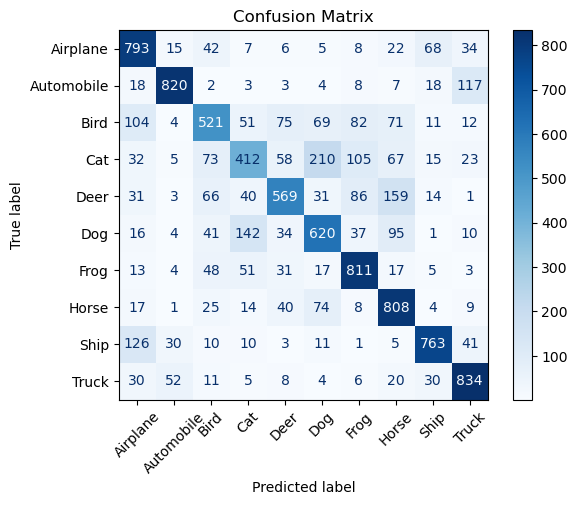

In [35]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)

In [36]:
#the matrix is diagonally hot,which is good.